In [1]:
import torch
import time
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Check if CUDA is available
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    # Print the number of available GPUs
    print(f"GPU Count: {torch.cuda.device_count()}")
    # Print the name of the current GPU
    print(f"Current GPU Name: {torch.cuda.get_device_name(0)}")
    
    # Optional: Run a test tensor on the GPU
    x = torch.randn(3, 3)
    x = x.to('cuda')
    print(f"Test Tensor Device: {x.device}")


PyTorch Version: 2.10.0+cu126
CUDA Available: True
GPU Count: 1
Current GPU Name: NVIDIA GeForce RTX 3060 Laptop GPU
Test Tensor Device: cuda:0


In [3]:
def create_matrices(size, device):
    assert device in ['cuda', 'mps', 'cpu']
    d = torch.device(device)
    A = torch.randn([size, size], dtype=torch.float32, device=d)
    B = torch.randn([size, size], dtype=torch.float32, device=d)
    return A, B


A, B = create_matrices(10000, 'cuda')
print("Matrix A: ")
print(A.shape)
print(A.dtype)
print(A.device)
print("Matrix B: ")
print(B.shape)
print(B.dtype)
print(B.device)


Matrix A: 
torch.Size([10000, 10000])
torch.float32
cuda:0
Matrix B: 
torch.Size([10000, 10000])
torch.float32
cuda:0


In [4]:
def benchmark_matmul(A, B):
    torch.cuda.synchronize()
    start = time.perf_counter()
    C = torch.mm(A, B)
    torch.cuda.synchronize()
    end = time.perf_counter()
    return (end - start) * 1000

benchmark_matmul(A, B)

1130.1019660022575

CUDA Benchmark:
10x10 = 144.8067169985734
10000x10000 = 578.9596600006917

CPU Benchmark:
10x10 = 12.376146994938608
10000x10000 = 4068.491357000312


In [5]:
def compare_pus(sizes):
    results = {
        "sizes" : sizes, 
        "cpu_times": [],
        "gpu_times" : [],
        "speedups" : []
    }
    print(f"{'Size ':>8} | {'CPU (ms) ':>12} | {'GPU (ms) ':>12} | {'Speedup':>10}")
    for size in sizes:
        #CPU Test
        A_cpu, B_cpu = create_matrices(size, 'cpu')
        cpu_time = benchmark_matmul(A_cpu, B_cpu)

        #GPU Test
        A_gpu, B_gpu = create_matrices(size, 'cuda')
        gpu_time = benchmark_matmul(A_gpu, B_gpu)

        speedup = cpu_time/gpu_time

        results["cpu_times"].append(cpu_time)
        results["gpu_times"].append(gpu_time)
        results["speedups"].append(speedup)
        print(f"{size:>8} | {cpu_time :>10.2f}ms | {gpu_time :>10.2f}ms | {speedup :>9.2f}x")
    return results
        
sizes = [512, 1024, 2048, 4096, 8192]
compare_pus(sizes)



   Size  |    CPU (ms)  |    GPU (ms)  |    Speedup
     512 |      20.69ms |      13.84ms |      1.49x
    1024 |      17.51ms |       2.30ms |      7.62x


    2048 |     109.24ms |       5.40ms |     20.23x
    4096 |     801.31ms |      53.36ms |     15.02x
    8192 |    4588.43ms |     553.39ms |      8.29x


{'sizes': [512, 1024, 2048, 4096, 8192],
 'cpu_times': [20.690892008133233,
  17.505733005236834,
  109.24106600577943,
  801.3137610105332,
  4588.4343039942905],
 'gpu_times': [13.843567998264916,
  2.2959699999773875,
  5.400964000727981,
  53.35878999903798,
  553.3862489974126],
 'speedups': [1.4946213296114503,
  7.624547796970015,
  20.22621628121482,
  15.017464995457736,
  8.291558224128812]}

   Size  |    CPU (ms)  |    GPU (ms)  |    Speedup
       4 |       0.30ms |       0.59ms |      0.50x
       8 |       0.04ms |       0.12ms |      0.33x
      16 |       0.03ms |       0.10ms |      0.32x
      32 |       0.02ms |       0.62ms |      0.04x
      64 |       0.22ms |       0.11ms |      1.99x
     128 |       0.07ms |       0.14ms |      0.47x
     256 |       0.25ms |       0.23ms |      1.08x
     512 |       1.20ms |       1.28ms |      0.94x
    1024 |       7.58ms |       4.91ms |      1.54x
    2048 |      47.90ms |      22.32ms |      2.15x
    4096 |     376.69ms |     193.53ms |      1.95x
    8192 |    2331.21ms |     361.36ms |      6.45x


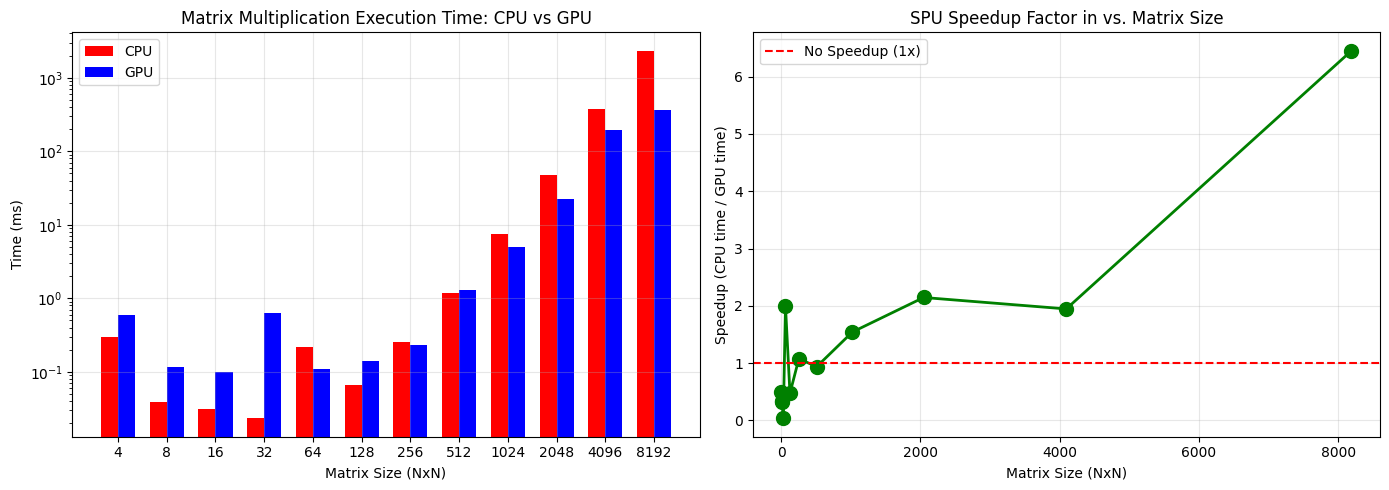

In [22]:
sizes = [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]
data = compare_pus(sizes)

fig, axes = plt.subplots(1,2,figsize=(14,5))

ax1 = axes[0]
x = np.arange(len(sizes))
width = 0.35

bars1 = ax1.bar(x-width/2, data['cpu_times'], width, label="CPU", color='red')
bars2 = ax1.bar(x+width/2, data['gpu_times'], width, label='GPU', color='blue')

ax1.set_xlabel('Matrix Size (NxN)')
ax1.set_ylabel('Time (ms)')
ax1.set_title('Matrix Multiplication Execution Time: CPU vs GPU')
ax1.set_xticks(x)
ax1.set_xticklabels([str(s) for s in sizes])
ax1.legend()
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
ax2.plot(sizes, data['speedups'], 'go-', linewidth=2, markersize=10)
ax2.axhline(y=1, color='r', linestyle='--', label='No Speedup (1x)')
ax2.set_xlabel('Matrix Size (NxN)')
ax2.set_ylabel('Speedup (CPU time / GPU time)')
ax2.set_title('SPU Speedup Factor in vs. Matrix Size')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
#plt.savefig('cuda_vs_cpu_benchmark.png', dpi=150, bbox_inches='tight')
plt.show()

Why is CUDA faster than a CPU for large scale matrix calculations?

A GPU has many slow cores as opposed to the CPU's few very fast cores. When performing tasks with many separate simple calculations the GPU's many cores allow thousands of calculations to be done at the same time. Even though the CPU is very fast at its few calculations, when the number of calculations reaches several magnitues larger than the number of cores the GPU will become a more viable option regardless of it's slower base speed. Matrix multiplications are a series of many independent calculations making them perfect for CUDA implementations.

1. What is the maximum speedup you observed? At what matrix size did this occur?

At a size of 8192x8192 the CUDA trial was 6.7 faster than the CPU trial. However, given the trend shown in the graph above if larger matrix sizes were added then they would likely continue to outperform the CPU at greater magnitudes.


2. Why is the synchronize() call necessary for accurate GPU timing? What would
happen if you removed it?

Synchronize() tells the program to wait until all gpu processes complete before continuing the code. This is crucial for CUDA executions because CUDA utilizes parallelization of complex tasks to achieve faster speeds. If any of the kernels fall behind when calculating a value that is referenced in future calculations then every other kernel will be stuck waiting for it to complete its task before they can continue.


3. Examine your results closely. Do you notice any trends or patterns in how speedup changes with matrix size? Research the architecture of your specific GPU or Apple Silicon device (number of cores, memory bandwidth, compute units, etc.) and write a hypothesis explaining why your timing results look the way they do. What architectural features might account for the performance characteristics you observed?

Once the matrix size goes above 256 x 256 the GPU outperforms the CPU every time. My laptop CPU is 8 cores while my GPU has 3840 shader/compute units (cores?). This explains why the GPU performs roughly the same regardless of matrix size until it tries the 4096 x 4096 trial. Until that point it only requires a single pass due to the massive number of cores but once multiple passes are needed doubling the size of the matrix roughly doubles the execution time. It is still worth noting however that GPU execution times increase at a much slower rate than CPU execution times.

4. Based on your results, at approximately what matrix size does using a GPU
become worthwhile? Explain your reasoning.

GPU processing only becomes useful when parallelization on slow GPU cores can outperform the linear processing of the CPU's fast cores. In the case of my computer this happens once matrix sizes pass ~256x256. At this point the few CPU cores can't compensate with their speed and the GPU's parallel processes and many cores become advantageous.